In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [2]:
%run nmt_run.py

  0%|          | 0/138708 [00:00<?, ?it/s]

translating es to en
callhome es-en configuration
--------------------------------------------------
loading info_dict from=./out/info.dict
--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 138708/138708 [00:00<00:00, 626383.26it/s]


--------------------------------------------------
saving info dict in: ./out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=64, width of each bucket=16
index | width | num   
    0 |     0 |      0
    1 |    16 |      0
    2 |    32 |      8
    3 |    48 |     67
    4 |    64 |    169
    5 |    80 |    184
    6 |    96 |    178
    7 |   112 |    202
    8 |   128 |    169
    9 |   144 |    138
   10 |   160 |    167
   11 |   176 |    124
   12 |   192 |    102
   13 |   208 |    108
   14 |   224 |     93
   15 |   240 |     95
   16 |   256 |     88
   17 |   272 |     80
   18 |   288 |     96
   19 |   304 |     82
   20 |   320 |     60
   21 |   336 |     67
   22 |   352 |     90
   23 |   368 |     64
   24 |   384 |     67
   25 |   400 |     47
   26 |   416 |     50
   27 |   432 |     56
   28 |   448 |     70
   29 |   464 |     47
   30 |   480 |     45
   31 |   496 |    

usage: nmt_run.py [-h] -o OUT_PATH -e EPOCHS -k KEY -y USE_Y -m MINI
nmt_run.py: error: the following arguments are required: -o/--out_path, -e/--epochs, -k/--key, -y/--use_y, -m/--mini


SystemExit: 2

In [3]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_lr_reg/seq2seq_sen-138819_hwy2-dec2_emb-512-h-512__sp_en_w_gru_drpt-0_noise-0.10_l2-0.001_cnn-num100-range9-49-10-pool500_40.model
loading ...
finished loading ..


In [4]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.loadtxt(log_dev_fil_name, delimiter=',', skiprows=False).transpose()

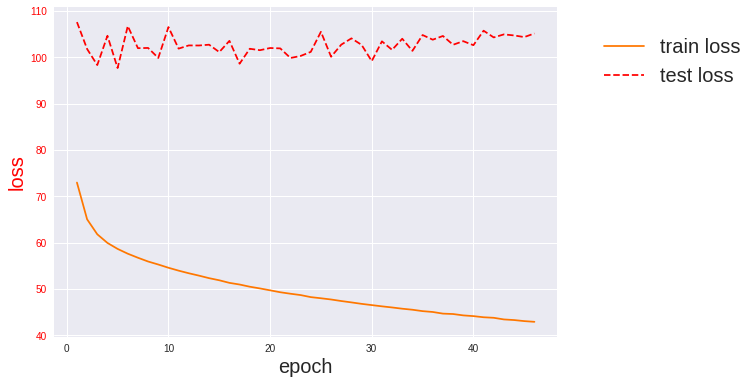

In [5]:
fig, ax1 = plt.subplots()
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=20)
ax1.set_ylabel('loss', color='r', size=20)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.4, 0.96), framealpha=0, fontsize=20)
plt.tight_layout()
plt.show()

In [6]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])

In [7]:
cat_speech_path = os.path.join(out_path, key)

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
pred_sents, utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|          | 0/3979 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 41


/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer2/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.functions.pooling.MaxPoolingND is experimental. The interface can change in the future.
  FutureWarning)
b=21,i=0/60,l=70.86,avg=106.44:  52%|█████▏    | 2076/3979 [00:23<00:24, 78.28it/s]   

In [ ]:
display_words(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)

In [ ]:
b, h, r = calc_bleu(m_dict, v_dict, pred_sents[:n], utts[:n], dec_key)
corpus_bleu(r, h)